In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing

plt.rcParams['figure.figsize'] = [16, 14]

In [2]:
def get_files():
    """Return a list of files to process

    Returns:
        list[str]: List of files to process
    """
    start_file = 9
    stop_file = 20

    image_files = []
    for i in range(stop_file - start_file):
        num = i + start_file
        image_files.append(f'/mnt/hgfs/ztemp/cal/ar0823at_{num:04}.bmp')

    print(image_files)
    return image_files

In [3]:
# Get the corners and subpixel corners. This is computationally expensive
def get_corners(image_file, CHECKERBOARD):
    """Get the subpixel corners.

    This is computationally expensive. So we wrap this operation in a function
    so we can spawn this function call in parallel

    Args:
        image_file (str): file to process
        CHECKERBOARD (tuple): Checkerboard configuration. This is the rows, cols of the inner corners

    Returns:
        tuple: A tuple containing the object points and the detected sub-pixel corners
    """
    objp = np.zeros((CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    image = cv2.imread(image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, None, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_NORMALIZE_IMAGE + cv2.CALIB_CB_FAST_CHECK)

    if ret:
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        return objp, corners2
    else:
        print('No points found')
        return None, None

In [4]:
# Chessboard dimensions: https://docs.opencv.org/4.10.0/d9/d0c/group__calib3d.html#ga93efa9b0aa890de240ca32b11253dd4a
# This is the patternSize
# patternSize	Number of inner corners per a chessboard row and column ( patternSize = cv::Size(points_per_row,points_per_colum) = cv::Size(columns,rows) ).
CHECKERBOARD = (7, 10)

# Run in parallel, because it is slow.
res = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(get_corners)(image_file, CHECKERBOARD) for image_file in get_files())

['/mnt/hgfs/ztemp/cal/ar0823at_0009.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0010.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0011.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0012.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0013.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0014.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0015.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0016.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0017.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0018.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0019.bmp']


In [5]:
# Put it all back into a single list instead of N number of lists per image file
objpoints = []
imgpoints = []
for i in range(len(res)):
    objpoints.append(res[i][0])
    imgpoints.append(res[i][1])

['/mnt/hgfs/ztemp/cal/ar0823at_0009.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0010.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0011.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0012.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0013.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0014.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0015.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0016.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0017.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0018.bmp', '/mnt/hgfs/ztemp/cal/ar0823at_0019.bmp']


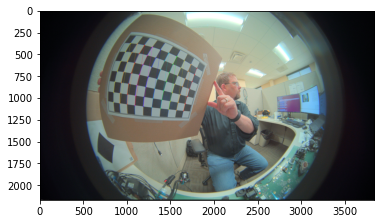

In [6]:
# Display the last image
image = cv2.imread(get_files()[-1])
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img = cv2.drawChessboardCorners(image, CHECKERBOARD, imgpoints[-1], True)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [7]:
# Calibrate the camera
N_OK = len(objpoints)
K = np.zeros((3, 3))
D = np.zeros((4, 1))
rvecs = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]
tvecs = [np.zeros((1, 1, 3), dtype=np.float64) for _ in range(N_OK)]

# Convert object points and image points to the required shape
objectPoints = [np.expand_dims(op, axis=1) for op in objpoints]
imagePoints = [np.expand_dims(ip, axis=1) for ip in imgpoints]

rms, _, _, _, _ = cv2.fisheye.calibrate(
    objectPoints, imgpoints, gray.shape[::-1], K, D, rvecs, tvecs,
    cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC,
    (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
)

print(K)
print(D)

[[ 7.22921900e+02 -2.25469580e+00  1.86412585e+03]
 [ 0.00000000e+00  7.25679049e+02  1.12015980e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 0.05061148]
 [-0.03047862]
 [ 0.04288224]
 [-0.02957817]]


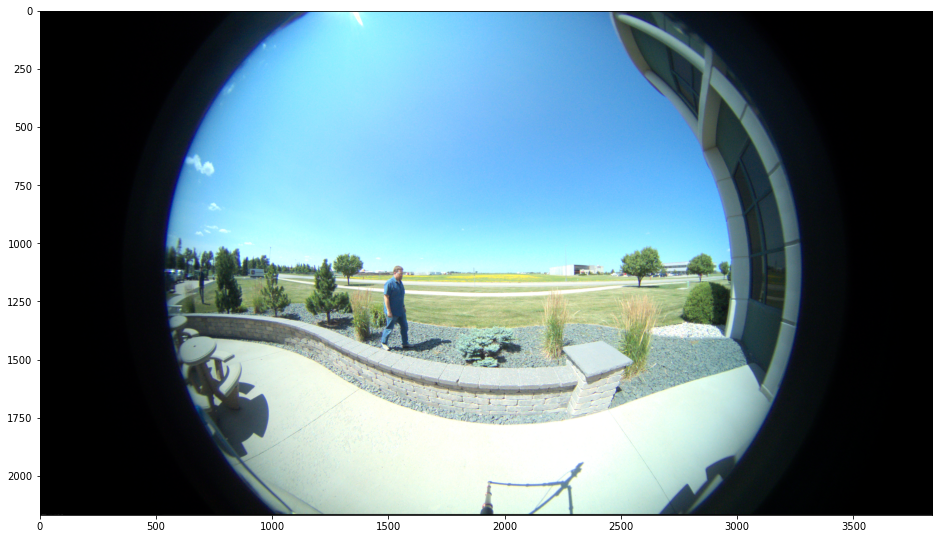

In [63]:
# Dewarp an image and display it
image = cv2.imread('/mnt/hgfs/ztemp/cap3/ar0823at_0002.bmp')
h, w, _ = image.shape
y1 = h // 2 - 320
y2 = h // 2 + 320
x1 = 2000
x2 = x1 + 640
roi = image[y1:y2, x1:x2]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

[[ 7.22921900e+02 -2.25469580e+00  1.86412585e+03]
 [ 0.00000000e+00  7.25679049e+02  1.12015980e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[ 7.22603699e+02 -2.25469580e+00  1.86330533e+03]
 [ 0.00000000e+00  7.25490051e+02  1.11986806e+03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[[0.31820086 0.         0.82052044]
 [0.         0.18899741 0.2917407 ]
 [0.         0.         0.        ]]


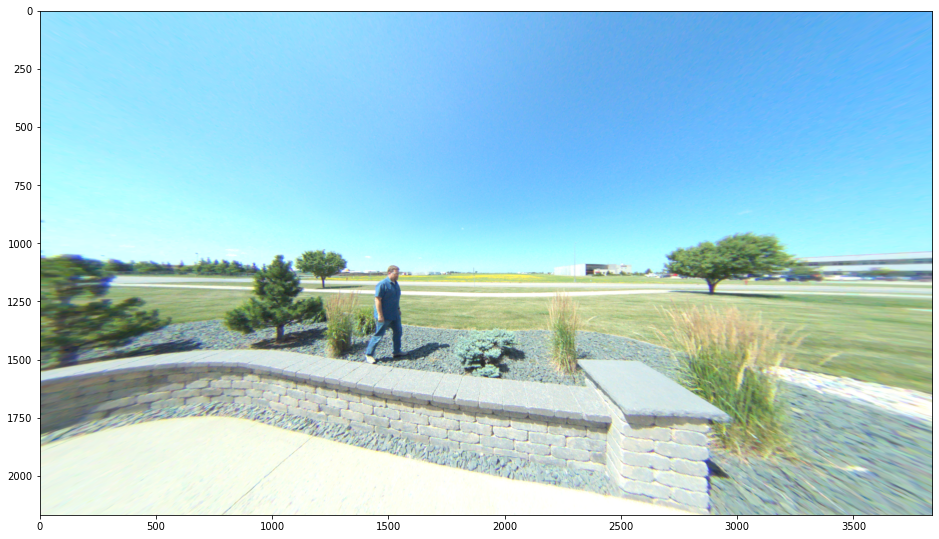

In [109]:
alpha = 0
new_K, roi_p = cv2.getOptimalNewCameraMatrix(K, D, (h, w), alpha)
print(K)
print(new_K)
print(K - new_K)
undistort2 = cv2.fisheye.undistortImage(image, K, D, Knew=new_K)

# R = np.eye(3)
# new_k = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(K, D, (w, h), R, balance=0.4)
# map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, R, new_k, (w, h), cv2.CV_16SC2)
# undistort2 = cv2.remap(image, map1, map2, cv2.INTER_CUBIC, cv2.BORDER_CONSTANT)


plt.imshow(cv2.cvtColor(undistort2, cv2.COLOR_BGR2RGB))